## Landmark based registration and Statistical Shape Analysis

**Deadline**: Upload this notebook (rename it as 'TP-ImaReg-LandmarkSSM-YOUR-SURNAME.ipynb') on E-Campus before the deadline. No need to zip it.

**Goal**: The goal of this notebook is to implement the algorithms seen today for landmarks based registration and statistical shape analysis. Please complete the code where you see **XXXXXXXXXXXXXX** and answer the questions.

We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) which is composed of several facial images annotated with 68 landmarks (already estimated and placed). Below, you will find a picture with an example. People express two emotions, either neutral or happy.

In [95]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
dest_path='./data/Data_FEI.npz')
gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
dest_path='./data/facial_landmarks_68markup.jpg')

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA


Now, let's load the data.

We have a list of images, the position of the landmarks (aligned to the images), the class labels Y (0 for neutral and 1 for happy) and the names of the images.

In [97]:
# Loading data
Working_directory="./data/"
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    Landmarks = data['Landmarks_FEI'] # original landmarks
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']
N,M = Landmarks.shape # number subjects
dim = 2
M = int(M/dim) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M)
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

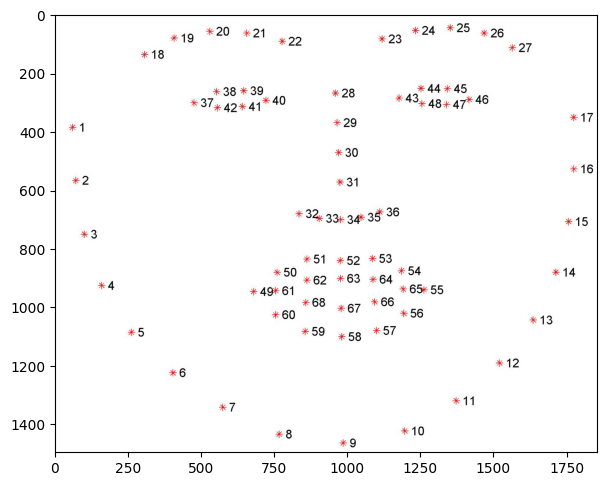

In [98]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (7,7)) # Size of the plot
plt.imshow(Example)
plt.show()

We randomly shuffle the data (even if it is not necessary for the TP)

In [99]:
# Shuffle data randomly
indeces=np.arange(N) # Integers from 0 to N-1
np.random.shuffle(indeces)

X=Landmarks[indeces]
Yp=Y[indeces]
Imagesp=Images[indeces]

Namesp=[''] * N
for i in range(0,N):
    Namesp[i]=Names[indeces[i]]


and we plot the first 6 (random) images with their respective landmarks

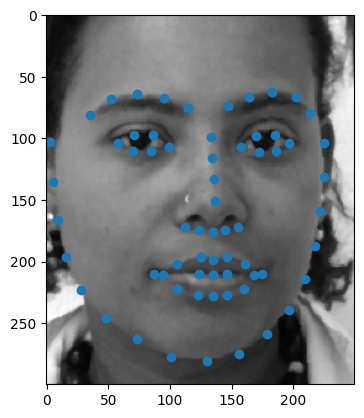

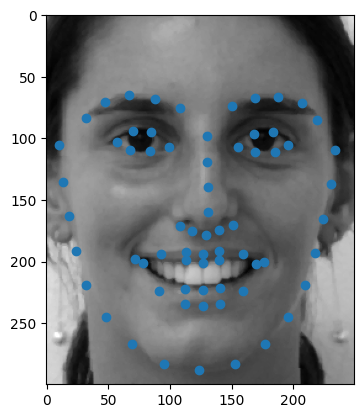

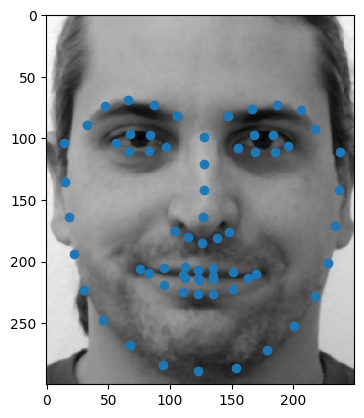

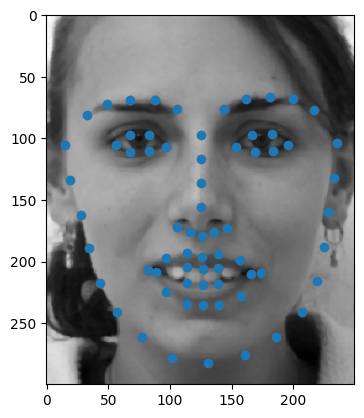

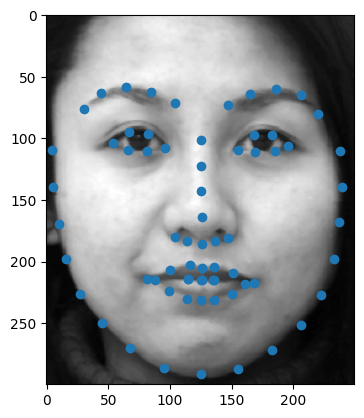

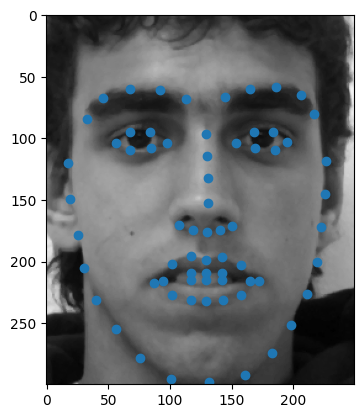

In [100]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

Now it's time to implement first the affine transformation and then the procrustes alignement (similarity transformation).
Please complete the code.

In [101]:
def AffineRegistrationLandmarks(x,y):

    '''
    Inputs:
               x: [M,2] array containing the M 2-dim source landmarks
               y: [M,2] array containing the M 2-dim target landmarks

    Outputs:
               xp: [M,2] array containing the M 2-dim aligned source landmarks
               T: [3,3] transformation matrix

    '''

    if x.shape[0] != y.shape[0] or x.shape[1] != y.shape[1]:
        raise NameError('data should have the same dimensions')

    if x.shape[1] != 2:
        raise NameError('This code works only for 2 dimensional data')

    M = x.shape[0]
    N = 3

    X = np.zeros((2*M,6))

    X[:M, :2] = x
    X[:M, 2] = 1
    X[M:, 3:5] = x
    X[M:, 5] = 1

    Y = np.concatenate((y[:, 0], y[:, 1]))

    Tp = np.linalg.inv(X.T @ X) @ X.T @ Y

    T = np.zeros((3,3))
    T[0,:] = Tp[:3].T
    T[1,:] = Tp[3:].T
    T[2,2] = 1

    Xp = X @ Tp

    xp = np.zeros((M,2))

    xp[:,0] = Xp[:M]
    xp[:,1] = Xp[M:]

    return xp,T


Let's test your implementation and see if it works.

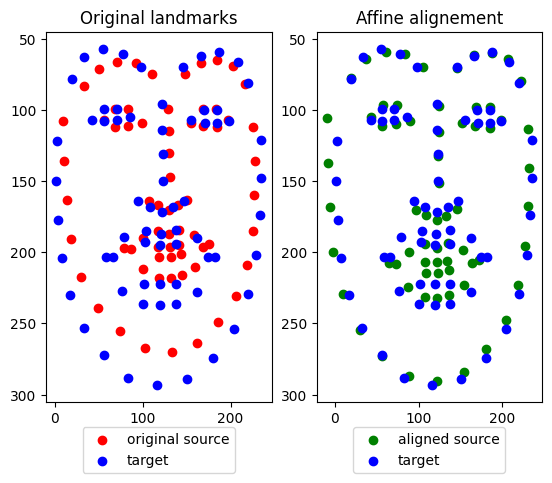

In [102]:
# Choose two random indeces between 0 and N-1
indexSource = np.random.randint(0, N)
indexTarget = np.random.randint(0, N)

# Choose if you want to plot data or not
show_plot=1

# Procrustes superimposition of two configurations
ls = X[indexSource] # source configuration
Is = Imagesp[indexSource,:,:]
lt = X[indexTarget] # target configuration
It = Imagesp[indexTarget,:,:]

# reshape landmarks configurations as matrices [M,2]
xs=np.reshape(ls,(M,dim))
xt=np.reshape(lt,(M,dim))

xpA,TA=AffineRegistrationLandmarks(xs,xt)

if show_plot==1:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.scatter(xs[:,0], xs[:,1], c='r',label='original source')
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
    plt.gca().invert_yaxis()
    plt.title('Original landmarks')
    plt.subplot(1, 2, 2)
    plt.scatter(xpA[:,0], xpA[:,1], c='g',label='aligned source')
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
    plt.gca().invert_yaxis()
    plt.title('Affine alignement')

Now, let's implement the procrustes alignement following the inputs and rules explained in the header of the function.

In [103]:
def procrustes_align(x,y,mode='best',verbose=1):

    """
    Inputs:
               X: [M,2] array containing the M 2-dim source landmarks
               Y: [M,2] matrix containing the M 2-dim target landmarks
               mode: 'rotation' to have only rotation, 'reflection' to
                   have only reflection and 'best' to have the one decided by the
                   data depending on det(U*V')
               verbose: 1 to have explanations and 0 otherwise

    Outputs:
               Xp: [M,2] array containing the aligned source landmarks
               s: uniform scaling
               R: rotation or reflection matrix
               t: translation vector
               SSR: sum of squared of residuals
               ratio_SSR: ratio of SSR with respect to the initial SSR

    """

    if mode.lower()!='best' and mode.lower()!='rotation' and mode.lower()!='reflection':
        raise NameError('Error ! mode should be equal to best, rotation or reflection')

    if x.shape[0] != y.shape[0] or x.shape[1] != y.shape[1]:
        raise NameError('data should have the same dimensions')

    if x.shape[1] != 2:
        raise NameError('This code works only for 2 dimennsional data')

    M=x.shape[0]

    # Center data
    xc = x - np.mean(x, axis=0)
    yc = y - np.mean(y, axis=0)

    # Optimal parameters (hint: use np.linalg.svd)
    U, D, Vt = np.linalg.svd(xc.T @ yc)
    D = np.diag(D)

    if mode.lower() == 'rotation':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation. Computing rotation.')
            S=np.eye(2)
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection but a rotation is computed as requested.')
            S=np.array([[1, 0], [0, np.linalg.det(U@Vt)]]) # to have det(U*V')=1
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
    elif mode.lower() == 'reflection':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation but a reflection is computed as requested.')
            S=np.array([[1, 0], [0, -np.linalg.det(U@Vt)]]) # to have det(U*V')=-1
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection. Computing reflection.')
            S=np.eye(2)
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
    elif mode.lower() == 'best':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation. Computing rotation.')
            S=np.eye(2)
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection. Computing reflection.')
            S=np.eye(2)
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')

    R = U @ S @ Vt
    s = np.trace(S @ D) / (np.linalg.norm(xc, ord='fro')**2)

    if mode.lower() == 'rotation':
        if np.absolute(np.linalg.det(R)-1)>1e-5:
            raise NameError('Error ! there is a problem...')
    if mode.lower() == 'reflection':
        if np.absolute(np.linalg.det(R)+1)>1e-5:
            raise NameError('Error ! there is a problem...')

    t = np.mean(y, axis=0) - s*(R.T @ np.mean(x, axis=0))
    xp = s*(x @ R) + t

    # Procrustes residuals
    SSR = np.sum(np.power((y-xp),2))

    # Ratio with initial residual
    SSR0 = np.sum(np.power((y-x),2))
    ratioSSR = SSR*100/SSR0

    return xp, s, R, t, SSR, ratioSSR

The best R is a rotation. Computing rotation.


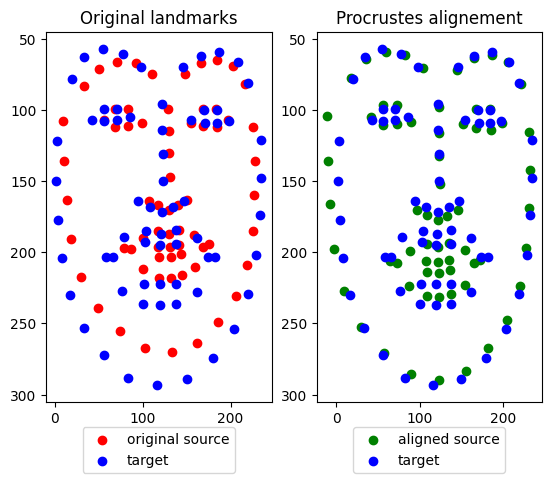

In [104]:
xp, s, R, t, SSR, ratioSSR = procrustes_align(xs,xt)

if show_plot==1:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.scatter(xs[:,0], xs[:,1], c='r',label='original source')
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
    plt.gca().invert_yaxis()
    plt.title('Original landmarks')
    plt.subplot(1, 2, 2)
    plt.scatter(xp[:,0], xp[:,1], c='g',label='aligned source')
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
    plt.gca().invert_yaxis()
    plt.title('Procrustes alignement')

**QUESTIONS**

*   What happens if you center the configurations before the alignment ?

If you center the configurations before the alignment it results with $t=0$ (no translation).

*   When do you expect a perfect alignment ?

When the source and the target have the same shape so that we can align our source using affine transformations.

Now, using the functions implemented in the previous jupyter-notebook apply the transformation computed with the affine and/or procrustes alignement to the source image.

In [105]:
def nearestNeighboutInterp(pM,I,coords=None):
    '''
    Nearest Neighbout interpolation

    Inputs:
        pM: 2D point defining the coordinates to interpolate
        I: image used for interpolation
        coords: coordinates of the image. If None, the coordinates of a pixel
                are automatically its row and column position

    Output:
        value: interpolated value at pM
    '''

    if coords is None:
        # row and column of pM
        r = int(pM[0])
        c = int(pM[1])

        # check if r and c are within the domain of I (I.shape)
        if 0 <= r < I.shape[0] and 0 <= c < I.shape[1] :
            value = I[r,c]
        else:
            value=0

    else:
        raise ValueError("Error ! Still not implemented")
        value=0

    return value

def InverseWarping(I,T,coords=None,outputShape=None):
    '''
    Apply inverse warping to an image I based on a transformation T.
    Transformation is defined by a 3x3 matrix

    Inputs:
        I: image to transform
        T: 3x3 matrix trasformation
        coords: coordinates of the image. If None, the coordinates of a pixel
                are automatically its row and column position
        outputShape: defines the shape of the transformed image.
                     It can be 'None', same shape as the input image I or 'BB',
                     bounding box of the transformed image I_T,  or a tuple/numpy
                     array with 4 elements (min x, max x, min y, max y)


    Output:
        J: transformed image
    '''

    if coords is None:

        if outputShape is None:
            outputShape=(0,I.shape[0],0,I.shape[1])

        elif outputShape == 'BB':
            coords = np.mgrid[0:I.shape[0], 0:I.shape[1]] # coordinates
            cm = applyTransformation(T,coords=coords)[1]
            #Find extremities bounding box
            bx=int(np.floor(np.min(cm[0,:,:])))
            ux=int(np.ceil(np.max(cm[0,:,:])))
            by=int(np.floor(np.min(cm[1,:,:])))
            uy=int(np.ceil(np.max(cm[1,:,:])))
            outputShape=(bx,ux,by,uy)

        elif isinstance(outputShape, tuple):
            if len(outputShape) != 4:
                raise ValueError("Error ! outputShape should be of length 4")

        elif isinstance(outputShape, np.ndarray):
            if len(outputShape) != 4:
                raise ValueError("Error ! outputShape should be of length 4")
        else:
            raise ValueError("Error ! outputShape should be None, 'BB' or a tuple/numpy array with 4 elements")

        J= np.zeros((outputShape[1] - outputShape[0], outputShape[3] - outputShape[2])) # transformed image

        for i in range(J.shape[0]):
            for j in range(J.shape[1]):

                p = np.array([i,j,1]) # coordinate of a pixel to transform
                pM = np.linalg.inv(T) @ p # transformed coordinate

                if pM[-1] != 0:
                  pM = pM/pM[-1] # normalization in case of homography

                  # shifting since the first pixel will be in (0,0) in the output image
                  if outputShape[0]<0:
                      x=i+abs(outputShape[0])
                  else:
                      x=i
                  if outputShape[2]<0:
                      y=j+abs(outputShape[2])
                  else:
                      y=j

                  J[x,y]=nearestNeighboutInterp(pM,I)

    else:
        raise ValueError("Error ! Still not implemented")

    return J

In [106]:
def applyTransformation(T, points=None, coords=None):
    '''
    Apply geometric transformation to points or image coordinates.
    Transformation is defined by a 3x3 matrix

    Inputs:
        points: Nx2 Numpy array of points
        coordinates: 2xNxM Numpy array of image coordinates
        T: 3x3 matrix trasformation

    Output:
        pm: Nx2 points after transformation
        cm: 2xNxM image coordinates after transformation
    '''
    if points is None and coords is None:
        raise ValueError("Error ! You should provide points and/or coords")

    if points is not None:
        N,d = points.shape
        if d != 2 and N==2:
            print('WARNING ! points should be an array of dimension Nx2'+
                  ' Transposing the array')
            points=points.T
            N,d = points.shape

        if d != 2:
            raise ValueError("Error ! Function works only with 2D points")

        # Transform points into homogeneous coordinates (adding one...)
        points =  np.c_[points, np.ones(N)]

        # Apply transformation
        points = np.dot(T,points.T).T

        # If homography, ...
        if(T[2][0] != 0 or T[2][1] !=0):
          points[:,:2] = points[:,:2]/(T[2,0]*points[:,:2] + T[2,1]*points[:,:2] + 1)

        pm = points[:,:2]
    else:
        pm=None

    if coords is not None:
        d,N,M = coords.shape

        if d != 2:
            raise ValueError("Error ! Function works only with 2D coordinates")

        p = coords.reshape((2,N*M)).T # reshape coordinates as list of points

        # Transform points into homogeneous coordinates (adding one...)
        p =  np.c_[p, np.ones(N*M)]

        # Apply transformation
        p = np.dot(T,p.T).T

        # If homography, ...
        if(T[2,0] != 0 or T[2,1] !=0):
          p[:,:2] = p[:,:2]/(T[2,0]*p[:,:2] + T[2,1]*p[:,:2] + 1)

        pm = p[:,:2].T
        cm = pm.reshape((2,N,M))
    else:
        cm =None

    return pm,cm

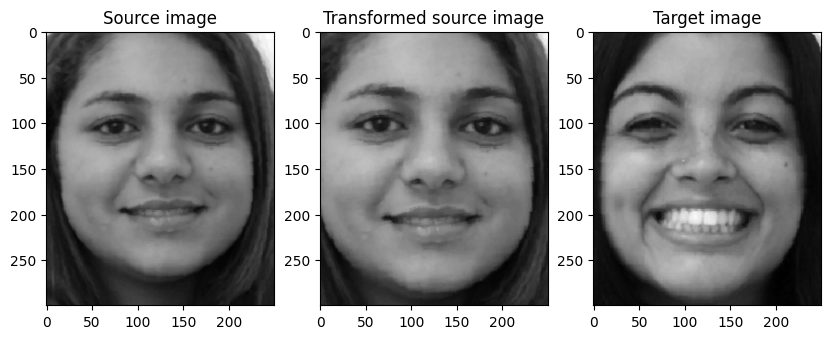

In [107]:
# compute T
T = np.array([
            [s*R[0,0], s*R[0,1], t[0]],
            [s*R[1,0], s*R[1,1], t[1]],
            [0, 0, 1]
            ])

Ism=InverseWarping(Is,T,outputShape=None)

fig = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax1.imshow(Is, cmap='gray')
ax1.set_title('Source image')
ax2.imshow(Ism, cmap='gray')
ax2.set_title('Transformed source image')
ax3.imshow(It, cmap='gray')
ax3.set_title('Target image')
plt.show()

Now let's implement the Generalized Procrustes Analysis (GPA) using the previously implemented procrustes alignement function.

As before, please follow the inputs and rules explained in the header of the function.

In [114]:
def generalized_procrustes_analysis(X,tau=1e-5,tangent=1):
  """
  Inputs:
            X: [N,2M] array containing N configurations of 2D landmarks.
               Each configuration has M landmarks
            tau: parameter for the stopping criteria (please refer to the slides
                 of the course)
            tangent: if set to 1, data will be projected onto the tangent space

  Outputs:
            Xm1: [M,2] array containing the landmarks of the average configuration
            Xcp: [N,2M] array containing the aligned landmarks onto Xm1

  """

  if X.shape[1] % 2 != 0:
        raise NameError('This code works only for 2 dimennsional data')

  # Parameters
  N,M=X.shape
  dim=2
  M=int(M/dim)

  # Plot original data
  plt.figure()
  for i in range(0,N):
      landmark=X[i]
      x=landmark[::2]
      y=landmark[1::2]
      plt.scatter(x, y, c='r')
  plt.gca().invert_yaxis()
  plt.title('Original landmarks')


  # Center each configuration
  Xc = np.zeros((N,M*dim))
  for i in range(0,N):
    Xc[i, ::2] = X[i, ::2] - np.mean(X[i, ::2])
    Xc[i, 1::2] = X[i, 1::2] - np.mean(X[i, 1::2])

  # Compute first average configuration
  Xm0 = np.mean(Xc, axis=0)

  # Plot configurations and first average
  plt.figure()
  for i in range(0,N):
      landmark=Xc[i]
      x=landmark[::2]
      y=landmark[1::2]
      plt.scatter(x, y, c='r')
  plt.scatter(Xm0[::2],Xm0[1::2],c='g',label='average')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.gca().invert_yaxis()
  plt.title('Centered data with first average')

  # Normalize average
  Xm0 = Xm0 / np.linalg.norm(((np.identity(M) - np.ones((M,M))/M) @ Xm0.reshape(M,dim)), ord='fro')

  # Procrustes alignement of all configurations to the average Xm0
  Xcp = np.zeros((N,M*dim))
  for i in range(0,N):
    xp, s, R, t, SSR, ratioSSR = procrustes_align(Xc[i].reshape((M, dim)), Xm0.reshape((M, dim)), 'best', 0)
    Xcp[i] = xp.reshape(M*dim)

  # Reshape average as vector
  Xm0 = Xm0.reshape((M*dim))

  # Plot configurations and average
  plt.figure()
  for i in range(0,N):
      landmark=Xcp[i]
      x=landmark[::2]
      y=landmark[1::2]
      plt.scatter(x, y, c='r')
  plt.scatter(Xm0[::2],Xm0[1::2],c='g',label='average')
  plt.gca().invert_yaxis()
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.title('Aligned data to normalized initial mean')

  # Tangent space projection
  if tangent==1:
      # landmarks after tangent space projection
      Xcpt=np.zeros((N,M*dim))
      # vector measuring the difference before/after projection
      diff = np.zeros((N,1))

      for i in range(0,N):
          Xcpt[i] = (np.linalg.norm(Xm0.reshape((M,dim)))**2)*Xcp[i] / (Xcp[i] @ Xm0)
          diff[i] = np.linalg.norm(Xcpt[i] - Xcp[i])

      # we look for the subject with the maximum difference before/after projection
      ind=np.argmax(diff)

      # Plot configurations and first average
      plt.figure()
      l=Xcp[ind]
      lt=Xcpt[ind]
      plt.scatter(l[::2], l[1::2], c='r', label='before projection')
      plt.scatter(lt[::2], lt[1::2], c='b', label='after projection')
      plt.gca().invert_yaxis()
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
      plt.title('Subject with maximum variation')

      plt.figure()
      for i in range(0,N):
          landmark=Xcp[i]
          x=landmark[::2]
          y=landmark[1::2]
          if i==ind:
              plt.scatter(x, y, c='b',label='Subject with max distortion', zorder=10)
          else:
              plt.scatter(x, y, c='r')

      plt.scatter(Xm0[::2],Xm0[1::2],c='g',label='average', zorder=5)
      plt.gca().invert_yaxis()
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
      plt.title('Subjects before projection')

      Xcp=Xcpt

  # Re-estimate average configuration
  Xm1 = np.mean(Xcp, axis=0)

  # Procrustes alignement of Xm1 to Xm0
  Xm1, s, R, t, SSR, ratioSSR = procrustes_align(np.reshape(Xm1,(M,dim)) ,np.reshape(Xm0,(M,dim)),'best' ,0)

  # Normalize new average Xm1
  Xm1 = Xm1 / np.linalg.norm(((np.identity(M) - np.ones((M,M))/M) @ Xm1), ord='fro')

  # Reshape average as vector
  Xm1 = Xm1.reshape((M*dim))

  # Plot configurations and new average
  plt.figure()
  for i in range(0,N):
      landmark=Xcp[i]
      x=landmark[::2]
      y=landmark[1::2]
      plt.scatter(x, y, c='r')
  plt.scatter(Xm1[::2],Xm1[1::2],c='g',label='average')
  plt.gca().invert_yaxis()
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.title('Aligned data to new mean')


  itera=1
  while np.sqrt(np.dot((Xm0-Xm1),(Xm0-Xm1))) > tau:
      print('Iter number %d , Error: %f' % (itera, np.sqrt(np.dot((Xm0-Xm1),(Xm0-Xm1))) ) )
      itera=itera+1

      # Update Xm0 to Xm1
      Xm0=Xm1

      # Procrustes alignement of all configurations to the average Xm0
      for i in range(0,N):
          temp=np.reshape(Xc[i],(M,dim))
          xp, s, R, t, SSR, ratioSSR = procrustes_align(temp,np.reshape(Xm0,(M,dim)),'best',0)
          Xcp[i]=np.reshape(xp,(M*dim))

      # Tangent space projection
      if tangent==1:
          for i in range(0,N):
              Xcp[i] = (np.linalg.norm(Xm0.reshape((M,dim)))**2)*Xcp[i] / (Xcp[i] @ Xm0)

      # Re-estimate average configuration
      Xm1 = np.mean(Xcp, axis=0)

      # Procrustes alignement of Xm1 to Xm0
      Xm1, s, R, t, SSR, ratioSSR = procrustes_align(np.reshape(Xm1,(M,dim)),np.reshape(Xm0,(M,dim)),'best',0)

      # Normalize new average Xm1
      Xm1 = Xm1 / np.linalg.norm(((np.identity(M) - np.ones((M,M))/M) @ Xm1), ord='fro')

      # Reshape average as vector
      Xm1 = np.reshape(Xm1,(M*dim))

      # Plot configurations and new average
      plt.figure()
      for i in range(0,N):
          landmark=Xcp[i]
          x=landmark[::2]
          y=landmark[1::2]
          plt.scatter(x, y, c='r')
      plt.scatter(Xm1[::2],Xm1[1::2],c='g',label='average')
      plt.gca().invert_yaxis()
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
      plt.title('GPA results after iter %i' % itera)


  return Xcp, Xm1


Let's test your implementation and see if it works.

Iter number 1 , Error: 0.000585


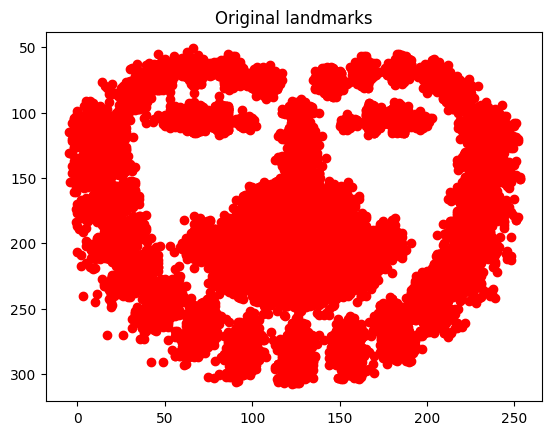

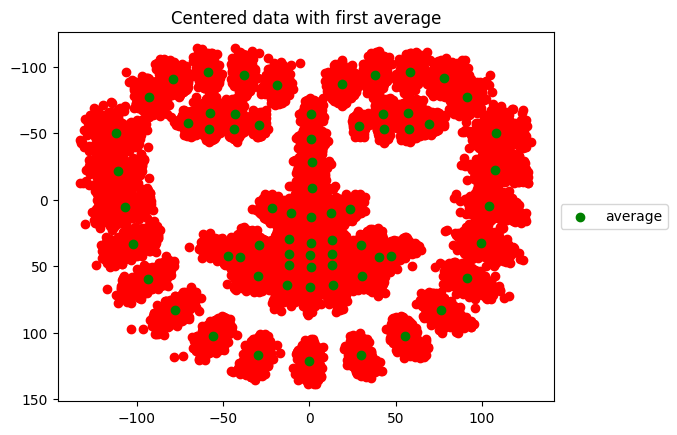

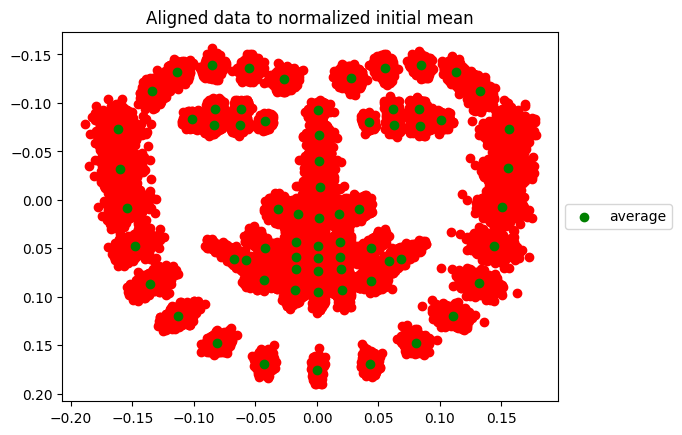

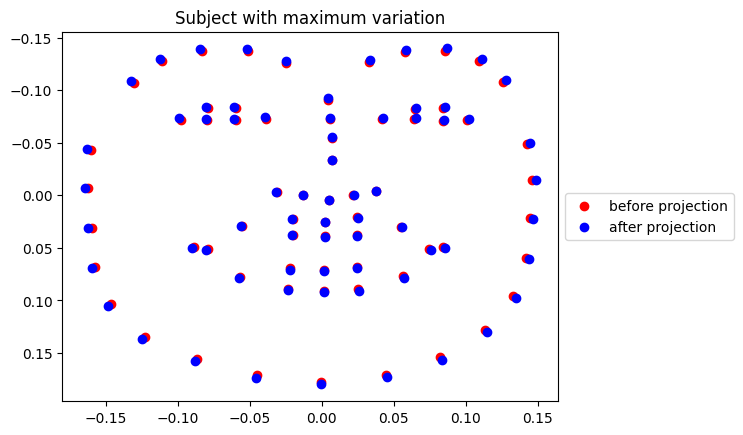

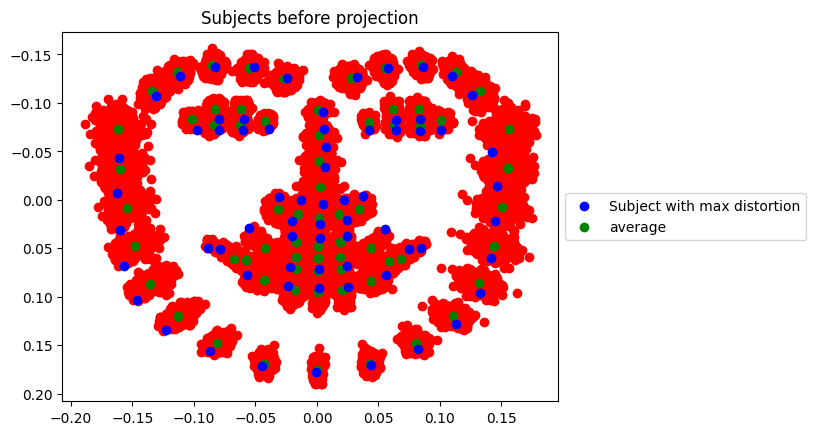

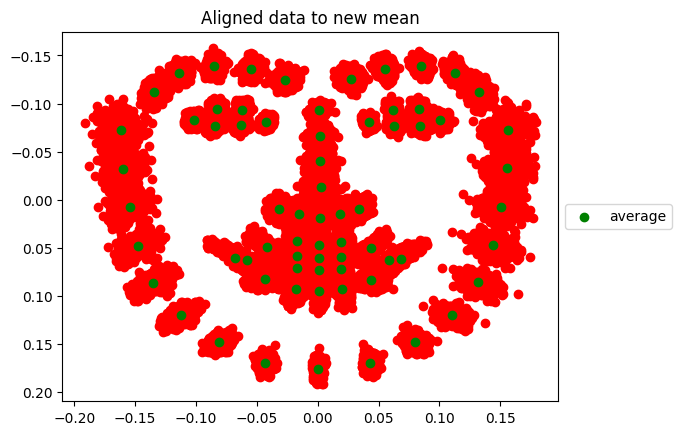

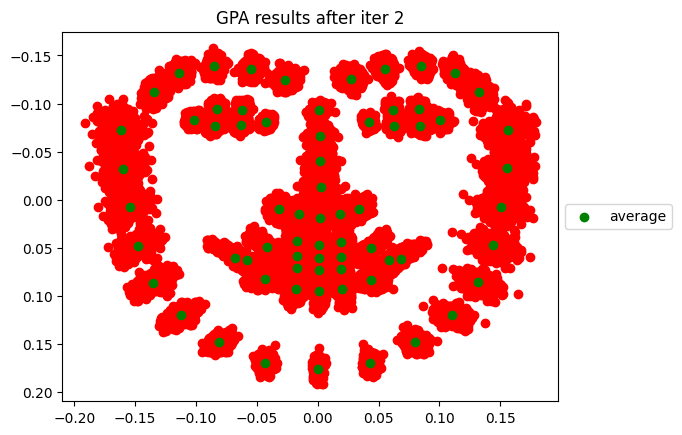

In [115]:
#  GPA (Generalized Procrustes Analysis)
Xcp, Xm1 = generalized_procrustes_analysis(X)

**QUESTIONS**


*   Try not to project the data onto the tangent space (i.e. `tangent=0`). Do the results vary ? Why in your opinion ? Hint: Look at the variability of the original data...

The results vary very slightly because the original data does not vary a lot.
So, the majority of the points should be close to the mean shape. Hence, the small difference between the geodesic and Euclidian distances.

*   Do the following four triangles have the same shape ? Explain why ?

The first three triangles have the same shape but not the last one because we cannot obtain it via an affine transformation of any of the first ones.

![shape.png](https://drive.google.com/uc?id=10OSJUfNDJ1xw6H3sRu7l3LRoojxju_4L)



Let's compute the shape variability using PCA. You will compute the three modes of deformations, as described in the slides of the lecture, at $\pm 3 \sigma$, where $\sigma$ is the standard deviation thus the square root of the the relative eigenvalue

The first three modes explain 29.685260, 25.140519 and 12.547151 of the total variability respectively


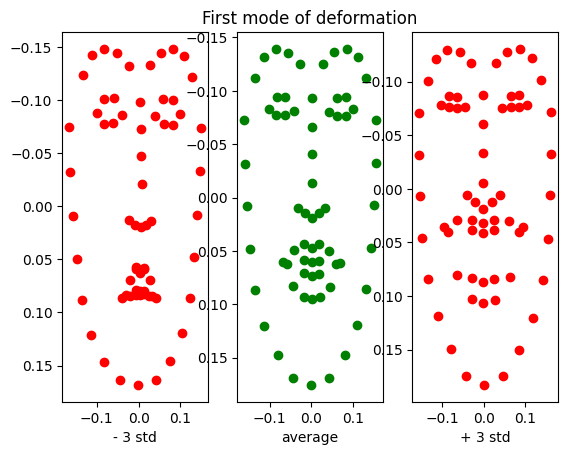

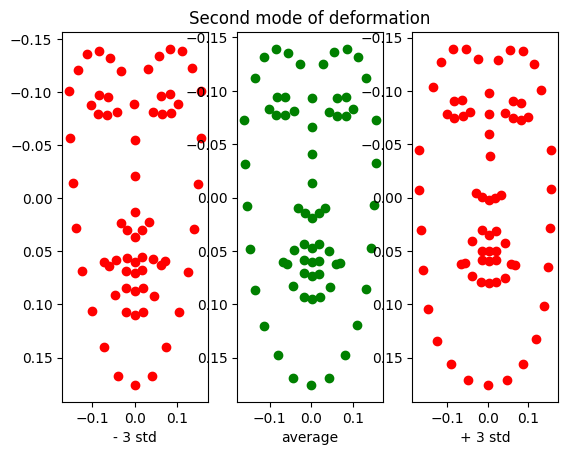

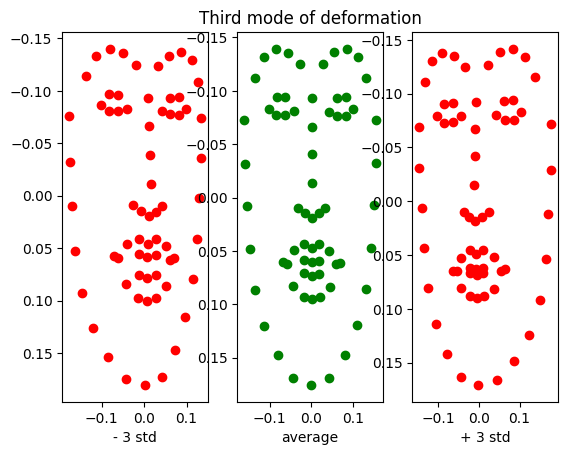

In [116]:
#%% Shape variability analysis
# we will use the scikit-learn implementation for PCA
from sklearn.decomposition import PCA

# PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Y=pca.fit_transform(Xcp)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues
var_explained = pca.explained_variance_ratio_*100 # variance explained

print('The first three modes explain %f, %f and %f of the total variability respectively' % (var_explained[0], var_explained[1], var_explained[2]))

# Compute first mode
first_mode_m = Xm1 - 3*np.sqrt(D[0])*U[:,0]
first_mode_p = Xm1 + 3*np.sqrt(D[0])*U[:,0]
# Compute second mode
second_mode_m = Xm1 - 3*np.sqrt(D[1])*U[:,1]
second_mode_p = Xm1 + 3*np.sqrt(D[1])*U[:,1]
# Compute third mode
third_mode_m = Xm1 - 3*np.sqrt(D[2])*U[:,2]
third_mode_p = Xm1 + 3*np.sqrt(D[2])*U[:,2]

if show_plot==1:
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.scatter(first_mode_m[::2], first_mode_m[1::2], c='r')
    plt.xlabel('- 3 std')
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 2)
    plt.scatter(Xm1[::2], Xm1[1::2], c='g')
    plt.xlabel('average')
    plt.title('First mode of deformation')
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 3)
    plt.scatter(first_mode_p[::2], first_mode_p[1::2], c='r')
    plt.xlabel('+ 3 std')
    plt.gca().invert_yaxis()

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.scatter(second_mode_m[::2], second_mode_m[1::2], c='r')
    plt.xlabel('- 3 std')
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 2)
    plt.scatter(Xm1[::2], Xm1[1::2], c='g')
    plt.xlabel('average')
    plt.title('Second mode of deformation')
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 3)
    plt.scatter(second_mode_p[::2], second_mode_p[1::2], c='r')
    plt.xlabel('+ 3 std')
    plt.gca().invert_yaxis()

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.scatter(third_mode_m[::2], third_mode_m[1::2], c='r')
    plt.xlabel('- 3 std')
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 2)
    plt.scatter(Xm1[::2], Xm1[1::2], c='g')
    plt.xlabel('average')
    plt.title('Third mode of deformation')
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 3)
    plt.scatter(third_mode_p[::2], third_mode_p[1::2], c='r')
    plt.xlabel('+ 3 std')
    plt.gca().invert_yaxis()


**QUESTIONS**


*   How many modes do you need to explain 90% of the variability ?

We need 9 modes to explain 90% of the variability.

*   Which anatomical variability do the first three modes show ? Was it expected ?

Mode 1 : Mouse shape variability\
Mode 2 : Face shape variability\
Mode 3 : Face horizontal angle variability

This result is expected (similar to what is shown in the course slides (page 59))

*   How could you check whether they show an anatomically plausible deformation ?

To check whether or not they show an anatomically plausible deformation we could test if each point of the database is containes inside these deformations.

*   Let's say that the anatomical deformation is not anatomically plausible, which kind of deformation would you use instead ? Why ?

We would use a deformation with higher standard deviation to encompass a larger set of faces.


In [117]:
cumulative_sum = 0
n = 0

for i, var in enumerate(var_explained):
    cumulative_sum += var

    if cumulative_sum >= 90:
        n = i + 1
        break

print('Number of modes needed to explain 90% of the variability:', n)


Number of modes needed to explain 90% of the variability: 9
